# **2- Imports**

In [1]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# **3- Data Preparation**

In [2]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)    

,dirname,filename
89,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
243,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii
222,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii
217,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii
252,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii


In [3]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-100.nii,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
4,../input/liver-tumor-segmentation-part-2/volume_pt8,volume-101.nii,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...,...,...
126,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-95.nii,../input/liver-tumor-segmentation/segmentations,segmentation-95.nii
127,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-96.nii,../input/liver-tumor-segmentation/segmentations,segmentation-96.nii
128,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-97.nii,../input/liver-tumor-segmentation/segmentations,segmentation-97.nii
129,../input/liver-tumor-segmentation-part-2/volume_pt6,volume-98.nii,../input/liver-tumor-segmentation/segmentations,segmentation-98.nii


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [6]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))

-3024.0 1410.0
0.0 2.0


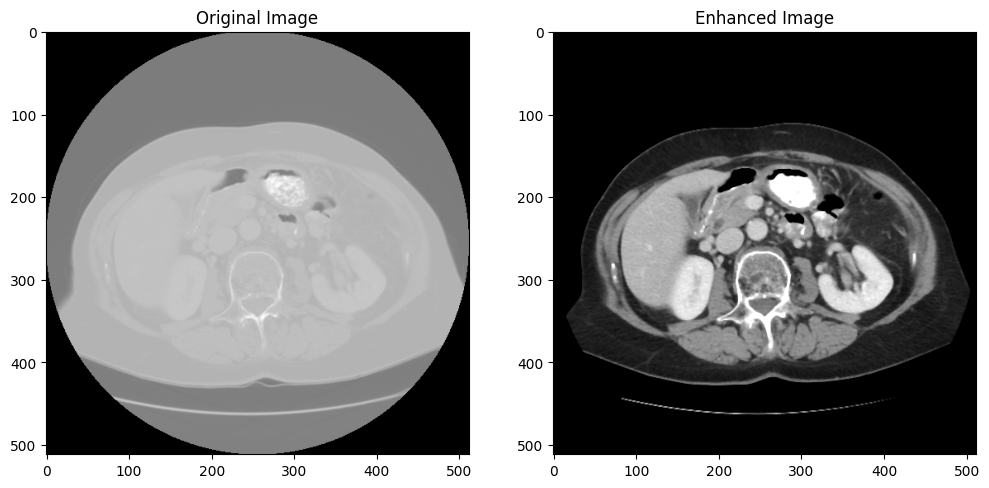

In [7]:
import cv2
import numpy as np
import pywt
from fastai.vision.all import *
import nibabel as nib

# Function to apply HU windowing to an image
def apply_hu_window(image, hu_min, hu_max):
    image = np.clip(image, hu_min, hu_max)
    image = (image - hu_min) / (hu_max - hu_min)
    return image

# Function to apply CLAHE to HU-windowed CT images
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Normalize the image to 16-bit unsigned
    image_16u = cv2.normalize(image, None, 0, 65535, cv2.NORM_MINMAX)
    
    # Convert the image to 16-bit unsigned before applying CLAHE
    image_16u = np.uint16(image_16u)
    
    # Apply CLAHE to the 16-bit image
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_result = clahe.apply(image_16u)
    
    # Convert the result back to the original data type
    clahe_result = clahe_result.astype(image.dtype)
    
    return clahe_result

# Function to apply Z-score normalization to an image
def apply_z_score(image):
    mean_value = np.mean(image)
    std_dev = np.std(image)
    z_score_image = (image - mean_value) / std_dev
    return z_score_image

# Function to apply median filter to an image
def apply_median_filter(image, kernel_size=3):
    # Convert the image to uint8
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Apply median blur
    median_blur_result = cv2.medianBlur(image_uint8, ksize=kernel_size)
    return median_blur_result

# Function to perform DWT enhancement
def enhance_resolution(image, wavelet='bior1.3', enhancement_factor=1.5):
    # Apply 2-level DWT
    coeffs = pywt.wavedec2(image, wavelet, level=2)
    
    # Modify each coefficient array to enhance resolution
    enhanced_coeffs = [tuple(c * enhancement_factor for c in coeff) for coeff in coeffs]
    
    # Reconstruct the enhanced image
    enhanced_image = pywt.waverec2(enhanced_coeffs, wavelet)
    
    return enhanced_image

# Load nii file using nibabel


# Define HU windowing parameters
hu_min = -150
hu_max = 250

# Apply HU windowing to the image
img_windowed = apply_hu_window(sample_ct, hu_min, hu_max)

# Apply CLAHE to the HU-windowed image
clahe_ct = np.zeros_like(img_windowed)
for i in range(img_windowed.shape[2]):
    clahe_ct[:,:,i] = apply_clahe(img_windowed[:,:,i])


# Apply Z-score normalization to the CLAHE-enhanced image
img_z_score = apply_z_score(clahe_ct)

# Apply median filter to the Z-score normalized image
img_median_filtered = apply_median_filter(img_z_score)

# Enhance resolution using DWT on the median-filtered image
img_enhanced = enhance_resolution(img_median_filtered)

# Display the original and enhanced images
figure(figsize=(12, 6), dpi=100)

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(sample_ct[..., 50], cmap='gray')
plt.title('Original Image')

# Enhanced Image
plt.subplot(1, 2, 2)
plt.imshow(img_enhanced[..., 50], cmap='gray')
plt.title('Enhanced Image')

plt.show()


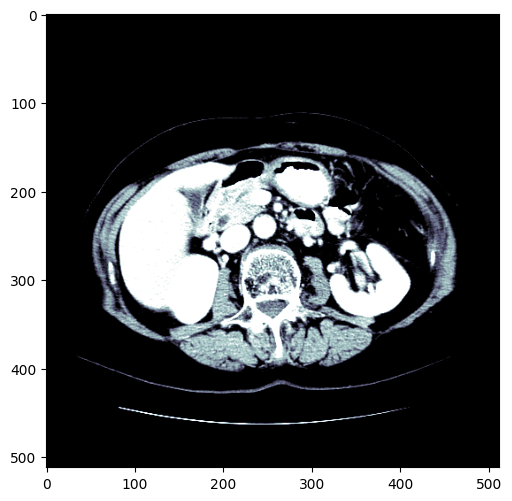

In [8]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 50].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [9]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
#     plt.imshow(img_enhanced[0])
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

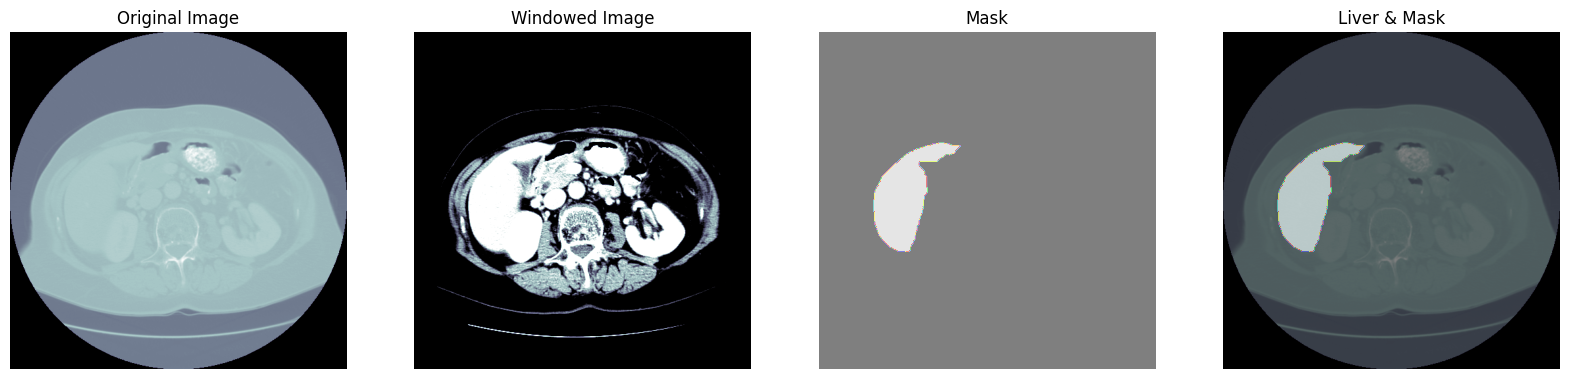

In [10]:
sample = 50

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

In [11]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


<AxesSubplot:>

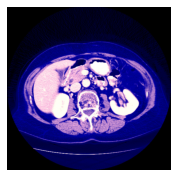

In [12]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()
    
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
    
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [13]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices 

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = tensor(curr_mask[...,curr_slice].astype(np.float32))
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save_jpg(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.jpg", [dicom_windows.liver,dicom_windows.custom])
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/44 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [14]:
#check value image
img = Image.open("/kaggle/working/test.jpg")
img = np.array(img)
# data = img.reshape((-1, 3))
# data.shape #RGB


# Model Training
### we gonna use the U-Net

In [15]:
# Create a meta file for nii files processing
file_list = []
mask_list = []
for dirname, _, filenames in os.walk('/kaggle/working/train_images'):
    for filename in filenames:
        file_list.append(filename) 

for dirname, _, filenames in os.walk('/kaggle/working/train_masks'):
    for filename in filenames:
        mask_list.append(filename) 

files = pd.DataFrame({"train": file_list, "mask": mask_list}) 

In [16]:
filename = []
for i in range(len(files)):
    root = "/kaggle/working/train_images"
    path = os.path.join(root, files["train"][i])
    filename.append(path)

In [17]:
mask = []
for i in range(len(files)):
    root = "/kaggle/working/train_masks"
    path = os.path.join(root, files["train"][i])
    mask.append(path)

In [18]:

df = pd.DataFrame(data={"filename": filename, 'mask' : mask})

In [19]:
df['mask'] = df['mask'].str.split(".").str[0] + "_mask.jpg"

(512, 512, 3)


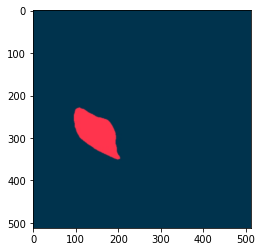

In [20]:
import cv2
import matplotlib.pyplot as plt

image= cv2.imread(df['mask'][50])
print(image.shape)
plt.imshow(image)
plt.show()

In [21]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size = 0.1, random_state = 42)
df_train, df_val = train_test_split(df_train,test_size = 0.2, random_state = 42)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(7264, 2)
(1817, 2)
(1009, 2)


In [22]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans
import sys
# from mode.config import *
np.set_printoptions(threshold=sys.maxsize, precision=5, suppress=True)

# arg = command_arguments()
#########################configuration########################
tumor = [120,0,0]
liver = [0,255,0]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([ tumor, liver, Unlabelled])
class_name = [ 'tumor', 'liver', 'None']  # You must define by yourself

color = 'grayscale'

num_classes = 3 # include cat, dog and None.
# num_of_test_img = arg.img_num

test_img_size = 256 * 256

img_size = (256,256)
###############################################################



def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255.
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        mask[(mask!=0.)&(mask!=255.)&(mask!=128.)] = 0.
        new_mask = np.zeros(mask.shape + (num_class,))
        ########################################################################
        #You should define the value of your labelled gray imgs
        #For example,the imgs in /data/catndog/train/label/cat is labelled white
        #you got to define new_mask[mask == 255, 0] = 1
        #it equals to the one-hot array [1,0,0].
        ########################################################################
        new_mask[mask == 255.,   0] = 1
        new_mask[mask == 128.,   1] = 1
        new_mask[mask == 0.,   2] = 1
        mask = new_mask

    elif(np.max(img) > 1):
        img = img / 255.
        mask = mask /255.
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator( batch_size, dataframe, aug_dict, image_color_mode = "grayscale",
                    mask_color_mode = "grayscale", image_save_prefix  = "image", mask_save_prefix  = "mask",
                    flag_multi_class = True, num_class = num_classes , save_to_dir = None, target_size = img_size, seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_dataframe(
        dataframe,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_dataframe(
        dataframe,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
#     print('classes:',image_generator.class_indices, mask_generator.class_indices)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

### You have to prepare validation data by your own while training
### If you prepared, add validation_data= "your own val path" in fit_generator in main.py
# def validationGenerator( batch_size, val_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
#                          mask_color_mode = "grayscale", image_save_prefix  = "image", mask_save_prefix  = "mask",
#                          flag_multi_class = True, num_class = num_classes , save_to_dir = None, target_size = img_size, seed = 1):

#     image_datagen = ImageDataGenerator()
#     mask_datagen  = ImageDataGenerator()
#     val_image_generator = image_datagen.flow_from_directory(
#         val_path+"image",
#         class_mode = None,
#         color_mode = image_color_mode,
#         target_size = target_size,
#         batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = image_save_prefix,
#         )
#     val_mask_generator = mask_datagen.flow_from_directory(
#         val_path+"label",
#         class_mode = None,
#         color_mode = mask_color_mode,
#         target_size = target_size,
#         batch_size = batch_size,
#         save_to_dir = save_to_dir,
#         save_prefix  = mask_save_prefix,
#         )
#     val_generator = zip(val_image_generator, val_mask_generator)
#     for (img,mask) in val_generator:
#         img ,mask = adjustData(img, mask, flag_multi_class, num_class)
#         yield (img,mask)

# def testGenerator(test_path,num_image = num_of_test_img, target_size = img_size, flag_multi_class=True, as_gray=True):
#     for i in range(num_image):
#         i = i + 1
#         img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
#         #img = img / 255.
#         img = trans.resize(img,target_size)
#         img = np.reshape(img,img.shape+(1,)) if (flag_multi_class) else img
#         img = np.reshape(img,(1,)+img.shape)
#         yield img


# ### You have to prepare test data by your own after training
# def testGenerator_for_evaluation(test_path, mask_path, num_image=num_of_test_img, num_class=num_classes ,target_size=(256,256), flag_multi_class = True, as_gray = True):
#     for i in range(num_image):
#         i = i + 1
#         # read test images
#         img = io.imread(os.path.join(test_path,"%d.png"%i), as_gray = as_gray)
#         img = trans.resize(img, target_size)
#         img = np.reshape(img,img.shape+(1,)) if (flag_multi_class) else img
#         img = np.reshape(img,(1,)+img.shape)
#         # read mask images
#         mask = io.imread(os.path.join(mask_path,"%d.png"%i), as_gray = as_gray)
#         mask = trans.resize(mask, target_size)
#         mask = np.expand_dims(mask,0)
#         mask = np.expand_dims(mask,-1)
#         mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
#         ###### filter noise points not related to the classes ######
#         mask[(mask!=0.)&(mask!=255.)&(mask!=128.)] = 0.
#         new_mask = np.zeros(mask.shape + (num_class,))
#         new_mask[(mask == 255.),   0] = 1
#         new_mask[(mask == 128.),   1] = 1
#         new_mask[(mask ==   0.),   2] = 1
#         mask = new_mask
#         yield (img,mask)



# ### draw imgs in labelVisualize and save results in saveResult
# def labelVisualize(num_class,  color_dict, img):
#     img_out = np.zeros(img[:,:,0].shape + (3,))
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             index_of_class = np.argmax(img[i,j])
#             img_out[i,j] = color_dict[index_of_class]
#     return img_out

# def saveResult(save_path,npyfile,flag_multi_class = True,num_class = num_classes ):
#     count = 1
#     for i,item in enumerate(npyfile):
#         if flag_multi_class:
#             img = labelVisualize(num_class,COLOR_DICT,item)
#             img = img.astype(np.uint8)
#             io.imsave(os.path.join(save_path,"%d.png"%count),img)
#         else:
#             img=item[:,:,0]
#             print(np.max(img),np.min(img))
#             img[img>0.5]=1
#             img[img<=0.5]=0
#             print(np.max(img),np.min(img))
#             img = img * 255.
#             io.imsave(os.path.join(save_path,"%d.png"%count),img)
#         count += 1


In [23]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
# from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# from mode.config import *
# from tensorflow.contrib.opt import AdamWOptimizer
from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.keras import backend as K
from keras.models import Model

img_size = (256,256,1) # 256 * 256 grayscale img with 1 channel

dr_rate = 0.6 # never mind
leakyrelu_alpha = 0.3

def unet(pretrained_weights = None,input_size = img_size):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)    
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(dr_rate)(pool1) ### 
    
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)
    #conv2 = Dropout(dr_rate)(conv2)###
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)    
    #conv2 = Dropout(dr_rate)(conv2)###    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)    
    #conv4 = Dropout(dr_rate)(conv4) ###
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)
    drop4 = Dropout(dr_rate)(conv4) ###
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    

    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)    
    conv5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #conv5 = Dropout(dr_rate)(conv5) ###
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #drop5 = Dropout(dr_rate)(conv5) ###

    up6 = Conv2D(512, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU(alpha=leakyrelu_alpha)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)
    #conv6 = Dropout(dr_rate)(conv6) ###
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)    
    #conv6 = Dropout(dr_rate)(conv6) ###   

    up7 = Conv2D(256, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = BatchNormalization()(up7)    
    up7 = LeakyReLU(alpha=leakyrelu_alpha)(up7)
    up7 = Dropout(dr_rate)(up7) ###
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)    
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)    
    #conv7 = Dropout(dr_rate)(conv7) ###
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)
    #conv7 = Dropout(dr_rate)(conv7) ###   

    up8 = Conv2D(128, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(alpha=0.3)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = LeakyReLU(alpha=0.3)(conv8)
    #conv8 = Dropout(dr_rate)(conv8) ###
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)    
    conv8 = LeakyReLU(alpha=0.3)(conv8)    
    #conv8 = Dropout(dr_rate)(conv8) ###    

    up9 = Conv2D(64, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(alpha=leakyrelu_alpha)(up9)
    up9 = Dropout(dr_rate)(up9) ###
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)    
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###

    conv10 = Conv2D(3, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)   
    model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model




In [24]:
import os
import os.path
# from model import *
# from data import *
from keras.models import load_model
from keras.callbacks import History
import tensorflow as tf
import matplotlib.pyplot as plt 
from keras import backend as K
# from mode.config import *
# from csvrecord import * 
from pathlib import Path
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

# arg = command_arguments()

# batch_size = arg.batchsize
# train_path = arg.train_path
# train_img_folder = arg.train_img_folder
# train_label_folder = arg.train_label_folder
# test_img_path = arg.test_img_path
# steps_per_epoch = arg.steps_per_epoch
# epochs = arg.epochs
# save_result_folder = arg.save_result_folder
# csvfilename = arg.csvfilename
# model_name = arg.model_name
# plt_save_name = arg.plt_save_name
# val_plt_name = arg.val_plt_name
# img_num = arg.img_num
# filenum = arg.filenum

# augs 

# rotation_range = arg.rotation_range
# width_shift_range = arg.width_shift_range
# height_shift_range = arg.height_shift_range
# zoom_range = arg.zoom_range
# horizontal_flip = arg.horizontal_flip
# fill_mode = arg.fill_mode


data_gen_args = dict()


#draw the training process of every epoch
def show_train_history(train_history, train, loss):
    plt.plot(train_history.history['acc'])
    plt.plot(train_history.history['loss'])
    plt.title('Train hist')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['acc','loss'], loc='upper left')
    plt.savefig(plt_save_name)


##### training
myGene = trainGenerator(12, df_val, data_gen_args, save_to_dir = None)


model = unet()
model_checkpoint = ModelCheckpoint('model_6', monitor='loss',verbose=1, save_best_only=True)
# Train the model and store the history
history = model.fit_generator(
    myGene, 
    steps_per_epoch=len(df_val) // 32,  # use integer division to get a whole number of steps
    epochs=5,
    validation_data=myGene,  # specify validation data
    validation_steps=len(df_val) // 32  # use integer division for validation steps
)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

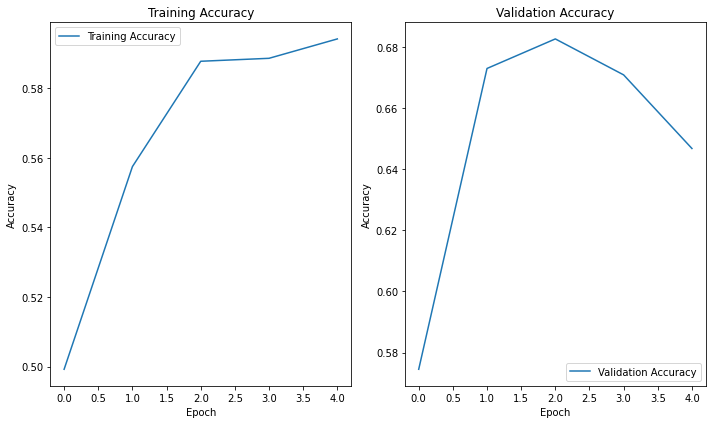

In [25]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

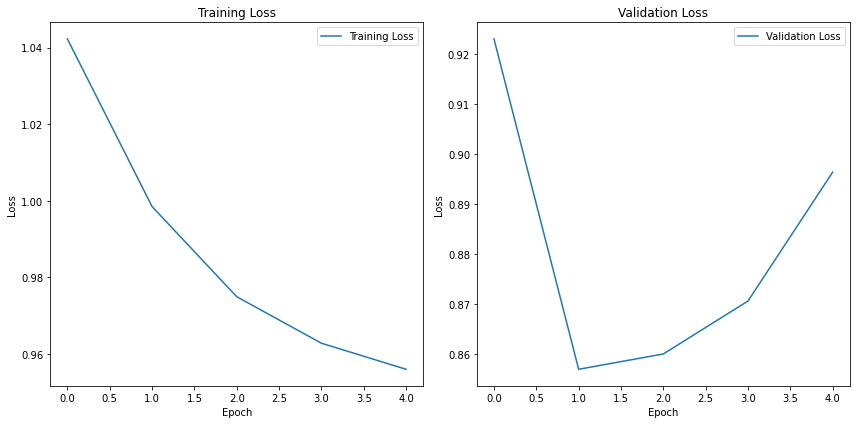

In [26]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
import numpy as np

# Assuming the shape of your masks is (256, 256) for simplicity
mask_shape = (256, 256)

# Generate random binary masks for y_true and y_pred
y_true = np.random.randint(2, size=mask_shape)
y_pred = np.random.randint(2, size=mask_shape)




In [28]:
import numpy as np

def dice_coefficient(y_true, y_pred, smooth=1.):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def iou(y_true, y_pred, smooth=1.):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

# Example usage:
# Assuming y_true and y_pred are the ground truth and predicted masks as numpy arrays
# with values 0 (background) and 1 (foreground)

# Calculate Dice coefficient
dice_score = dice_coefficient(y_true, y_pred)
print(f"Dice coefficient: {dice_score}")

# Calculate IoU score
iou_score = iou(y_true, y_pred)
print(f"IoU score: {iou_score}")

Dice coefficient: 0.49967182085998196
IoU score: 0.3330484678305457


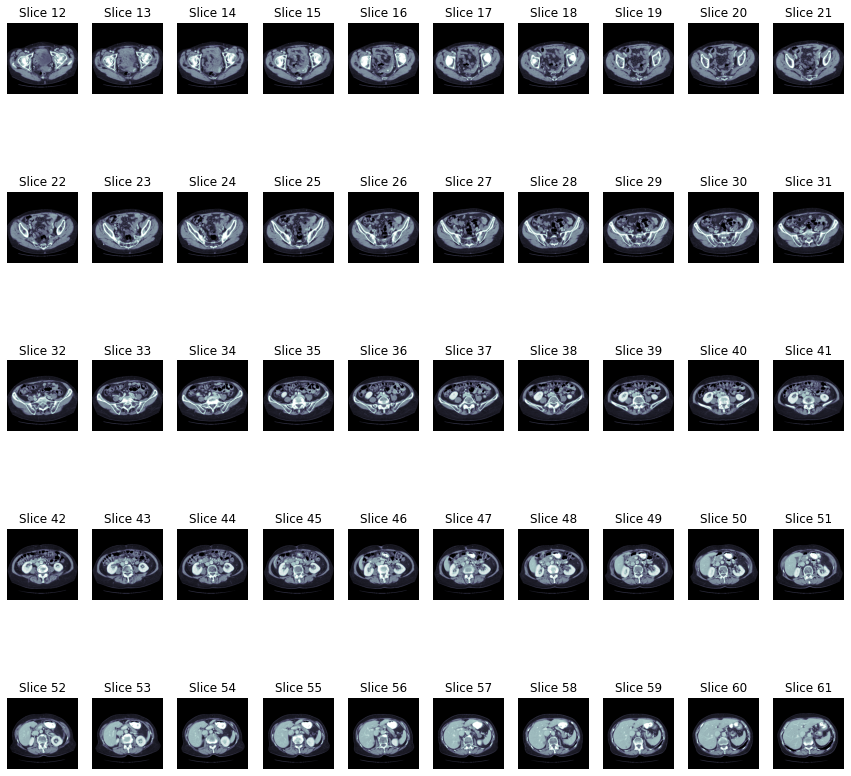

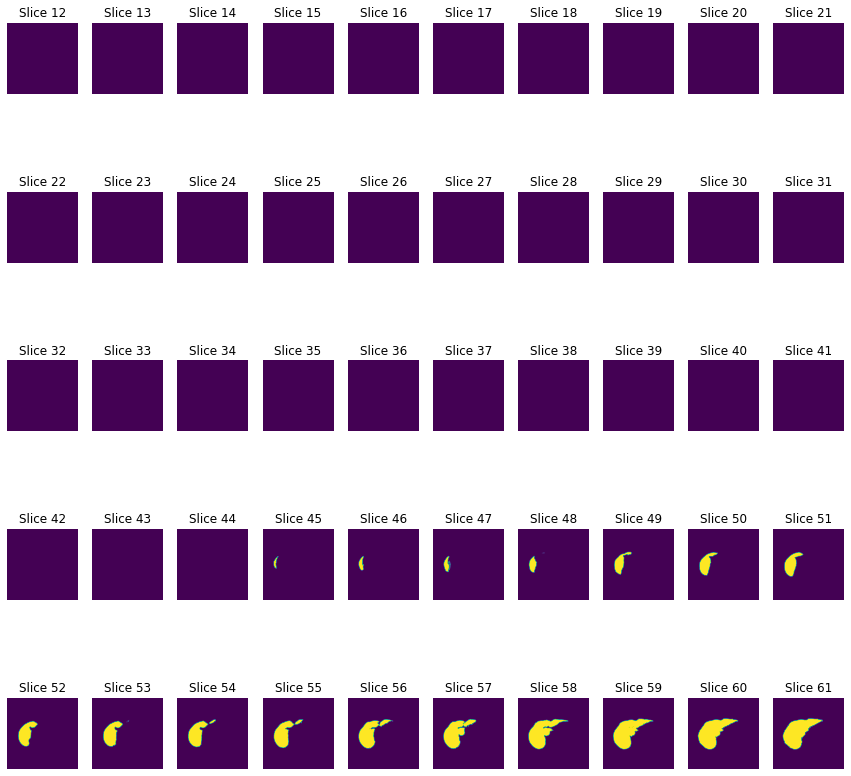

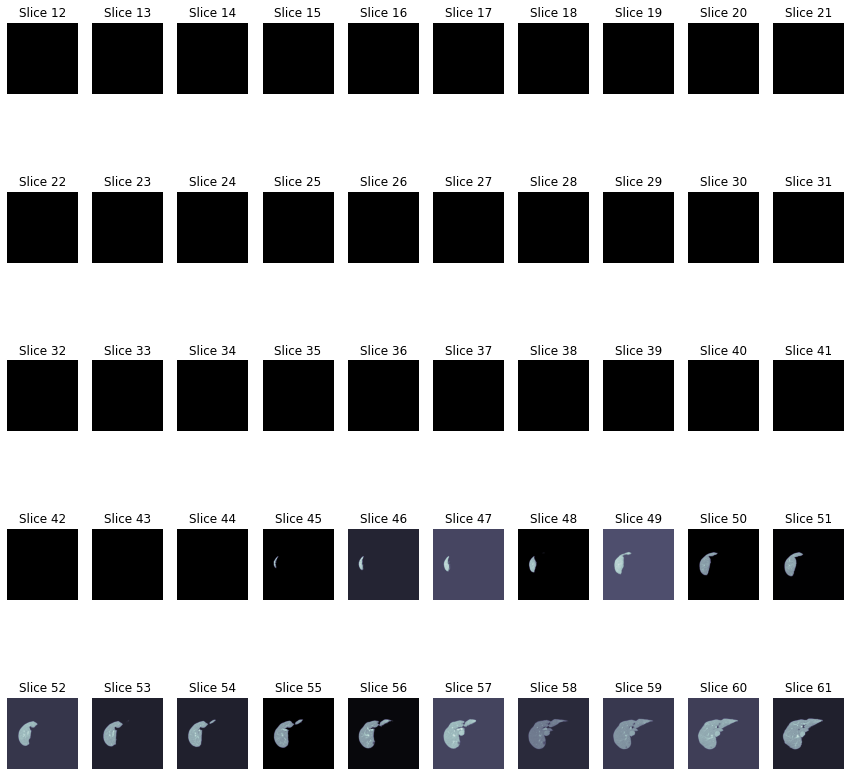

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_segmentation(ct_scan, predicted_mask, threshold=0.5, num_slices=50):
    # Apply threshold to the predicted mask
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Extract the liver region using the predicted mask
    segmented_liver = ct_scan.copy()
    segmented_liver[predicted_mask == 0] = 0

    # Get the center slice index
    center_slice = ct_scan.shape[2] // 2

    # Display the original CT scan, predicted mask, and segmented liver for 50 slices
    plt.figure(figsize=(15, 15))

    for i in range(center_slice - num_slices // 2, center_slice + num_slices // 2):
        plt.subplot(5, 10, i - (center_slice - num_slices // 2) + 1)

        # Original CT Scan
        plt.imshow(img_enhanced[..., i], cmap='bone')
        plt.title(f'Slice {i}')
        plt.axis('off')

    plt.show()

    plt.figure(figsize=(15, 15))

    for i in range(center_slice - num_slices // 2, center_slice + num_slices // 2):
        plt.subplot(5, 10, i - (center_slice - num_slices // 2) + 1)

        # Predicted Mask
        plt.imshow(predicted_mask[..., i], cmap='viridis')
        plt.title(f'Slice {i}')
        plt.axis('off')

    plt.show()

    plt.figure(figsize=(15, 15))

    for i in range(center_slice - num_slices // 2, center_slice + num_slices // 2):
        plt.subplot(5, 10, i - (center_slice - num_slices // 2) + 1)

        # Segmented Liver
        plt.imshow(segmented_liver[..., i], cmap='bone')
        plt.title(f'Slice {i}')
        plt.axis('off')

    plt.show()

# Assuming sample_ct is your original CT scan and sample_mask is your predicted mask
visualize_segmentation(sample_ct, sample_mask, num_slices=50)


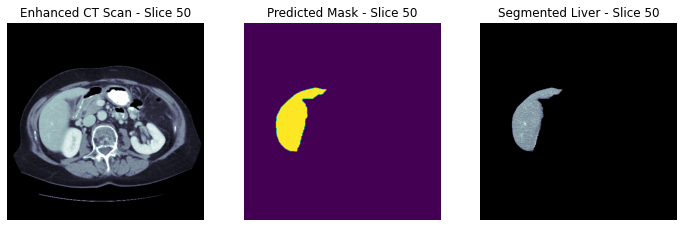

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_segmentation(ct_scan, predicted_mask, threshold=0.5, slice_number=50):
    # Apply threshold to the predicted mask
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Extract the liver region using the predicted mask
    segmented_liver = ct_scan.copy()
    segmented_liver[predicted_mask == 0] = 0

    # Display the original CT scan, predicted mask, and segmented liver for the specified slice
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_enhanced[..., slice_number], cmap='bone')
    plt.title(f'Enhanced CT Scan - Slice {slice_number}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask[..., slice_number], cmap='viridis')
    plt.title(f'Predicted Mask - Slice {slice_number}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented_liver[..., slice_number], cmap='bone')
    plt.title(f'Segmented Liver - Slice {slice_number}')
    plt.axis('off')

    plt.show()

# Assuming sample_ct is your original CT scan and sample_mask is your predicted mask
visualize_segmentation(sample_ct, sample_mask, slice_number=50)
